# Optimized Keras Sequential Conv1D version

In [1]:
# io
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Scientific Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Visualization
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.offline as py
import plotly.graph_objs as go

# Audio
import IPython.display as ipd

# Deep learning
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

import random
import copy
import librosa

%matplotlib inline

In [2]:
print(os.listdir('../input/tensorflow-speech-recognition-challenge/'))

['link_to_gcp_credits_form.txt', 'test.7z', 'sample_submission.7z', 'train.7z']


In [ ]:
!pip  install pyunpack 

In [9]:
!pip install patool

     |████████████████████████████████| 81kB 4.5MB/s eta 0:00:011


In [10]:
from pyunpack import Archive
path = r'/kaggle/input/tensorflow-speech-recognition-challenge/train.7z'
out = r'/kaggle/working/'
Archive(path).extractall(out)

In [11]:
train_audio_path = r'/kaggle/working/train/audio'
print(os.listdir(train_audio_path))

['two', 'house', 'on', 'bed', 'yes', 'five', 'four', 'down', 'zero', 'left', 'tree', 'cat', 'nine', 'seven', 'up', 'go', 'dog', 'no', 'three', 'sheila', 'right', 'stop', 'eight', '_background_noise_', 'one', 'six', 'off', 'bird', 'marvin', 'happy', 'wow']


In [12]:
# Load Data
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs[1:])))
print(dirs)

Number of labels: 30
['_background_noise_', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']


In [13]:
all_wav = []
unknow_wav = []
label_all = []
label_value = {}
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unknow_list = set([d for d in dirs if d not in target_list and d != '_background_noise_'])
print('target_list: ', end='')
print(target_list)
print('unknowns_list: ', end='')
print(unknow_list)
print('silence: _background_noise_')
background = [f for f in os.listdir(join(train_audio_path, '_background_noise_')) if f.endswith('.wav')]
background_noise = []
for wav in background:
    samples, sample_rate = librosa.load(join(train_audio_path, '_background_noise_', wav))
    samples = librosa.resample(samples, sample_rate, 8000)
    background_noise.append(samples)
for i,d in enumerate(dirs[1:]):
    waves = [f for f in os.listdir(join(train_audio_path, d)) if f.endswith('.wav')]
    label_value[d] = i
    print(str(i)+':'+str(d)+' ', end='')
    for wav in waves:
        samples, sample_rate = librosa.load(join(train_audio_path, d, wav), sr=16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if len(samples) != 8000: continue
        if d in unknow_list:
            unknow_wav.append(samples)
        else:
            label_all.append(d)
            all_wav.append([samples, d])

target_list: ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unknowns_list: {'two', 'dog', 'wow', 'happy', 'one', 'bird', 'house', 'nine', 'sheila', 'five', 'six', 'eight', 'cat', 'marvin', 'zero', 'four', 'bed', 'tree', 'seven', 'three'}
silence: _background_noise_
0:bed 1:bird 2:cat 3:dog 4:down 5:eight 6:five 7:four 8:go 9:happy 10:house 11:left 12:marvin 13:nine 14:no 15:off 16:on 17:one 18:right 19:seven 20:sheila 21:six 22:stop 23:three 24:tree 25:two 26:up 27:wow 28:yes 29:zero 

In [15]:
# split wav, label
wav_all = np.reshape(np.delete(all_wav, 1, 1), (len(all_wav)))
label_all = [i for i in np.delete(all_wav, 0, 1).tolist()]

In [16]:
# Data Augmentation, 10% amplitude from 8000 samples in 1 sec noise
def get_one_noise(noise_num=0):
    selected_noise = background_noise[noise_num]
    start_idx = random.randint(0, len(selected_noise)-1-8000)
    return selected_noise[start_idx:(start_idx + 8000)]

In [17]:
max_ratio = 0.1
noised_wav = []
augment = 1
delete_index = []
for i in range(augment):
    new_wav = []
    noise = get_one_noise(i)
    for i, s in enumerate(wav_all):
        if len(s) != 8000:
            delete_index.append(i)
            continue
        s += max_ratio * noise
        noised_wav.append(s)
np.delete(wav_all, delete_index)
np.delete(label_all, delete_index)

array(['down', 'down', 'down', ..., 'yes', 'yes', 'yes'], dtype='<U5')

In [18]:
wav_vals = np.array([x for x in wav_all])
label_vals = [x for x in label_all]
wav_vals.shape

(21312, 8000)

In [19]:
labels = copy.deepcopy(label_vals)
for _ in range(augment):
    label_vals = np.concatenate((label_vals, labels), axis=0)
label_vals = label_vals.reshape(-1, 1)

In [20]:
# Random sampling from unknown wav data
unknown = unknow_wav
augment_unknown = 2
np.random.shuffle(unknow_wav)
unknown = np.array(unknown)
unknown = unknown[:2000*(augment_unknown+1)]
unknown_label = np.array(['unknown' for _ in range(2000*(augment_unknown+1))])
unknown_label = unknown_label.reshape(2000*(augment_unknown+1), 1)

In [21]:
# some data may have different length, so delete them
delete_index = []
for i, w in enumerate(unknown):
    if len(w) != 8000:
        delete_index.append(i)
unknown = np.delete(unknown, delete_index, axis=0)
unknown_label = np.delete(unknown_label, delete_index, axis=0)

In [22]:
# Random samping from 'background_noise'
silence_wav = []
augment_silence = 1
num_wav = (2000*(augment_silence+1)) // len(background_noise)
for i, _ in enumerate(background_noise):
    for _ in range((2000*(augment_silence+1))//len(background_noise)):
        silence_wav.append(get_one_noise(i))
silence_wav = np.array(silence_wav)
silence_label = np.array(['silence' for _ in range(num_wav*len(background_noise))])
silence_label = silence_label.reshape(-1, 1)
silence_wav.shape, silence_label.shape

((3996, 8000), (3996, 1))

In [23]:
shape_ = (-1, 8000)
wav_vals = np.reshape(wav_vals, shape_)
noised_wav = np.reshape(noised_wav, shape_)
unknown = np.reshape(unknown, shape_)
silence_wav = np.reshape(silence_wav, shape_)

In [24]:
# check dimensions
print(wav_vals.shape)
print(noised_wav.shape)
print(unknown.shape)
print(silence_wav.shape)

(21312, 8000)
(21312, 8000)
(6000, 8000)
(3996, 8000)


In [25]:
print(label_vals.shape)
print(unknown_label.shape)
print(silence_label.shape)

(42624, 1)
(6000, 1)
(3996, 1)


In [26]:
# concatenate wavs, labels
wav_vals = np.concatenate((wav_vals, noised_wav), axis=0)
wav_vals = np.concatenate((wav_vals, unknown), axis=0)
wav_vals = np.concatenate((wav_vals, silence_wav), axis=0)

In [27]:
label_vals = np.concatenate((label_vals, unknown_label), axis=0)
label_vals = np.concatenate((label_vals, silence_label), axis=0)

In [28]:
len(wav_vals), len(label_vals)

(52620, 52620)

In [ ]:
# Prepare train and validation data
# train_wav, test_wav, train_label, test_label = train_test_split(wav_vals, label_vals,\
#     test_size=0.2, random_state=1993, shuffle=True)

In [29]:
# Prepare train data
train_wav, train_label = shuffle(wav_vals, label_vals)

In [30]:
print(len(train_wav))
# print(len(test_wav))

52620


In [31]:
# Hyper-parameters
lr = .001
generations = 20000
num_gens_to_wait = 250
batch_size = 512
drop_out_rate = .5
input_shape = (8000, 1)

In [32]:
train_wav.shape

(52620, 8000)

In [48]:
# For Conv1D and Channel
train_wav = train_wav.reshape(-1, 8000, 1)
#test_wav = test_wav.reshape(-1, 8000, 1)

NameError: name 'test_wav' is not defined

In [34]:
print(train_wav.shape)
# print(test_wav.shape)

(52620, 8000, 1)


In [35]:
label_value = target_list
label_value.append('unknown')
label_value.append('silence')

In [36]:
new_label_value = {}
for i, la in enumerate(label_value):
    new_label_value[la] = i
label_value = new_label_value
label_num2word = {v:k for k, v in label_value.items()}

In [37]:
label_value, label_num2word

({'yes': 0,
  'no': 1,
  'up': 2,
  'down': 3,
  'left': 4,
  'right': 5,
  'on': 6,
  'off': 7,
  'stop': 8,
  'go': 9,
  'unknown': 10,
  'silence': 11},
 {0: 'yes',
  1: 'no',
  2: 'up',
  3: 'down',
  4: 'left',
  5: 'right',
  6: 'on',
  7: 'off',
  8: 'stop',
  9: 'go',
  10: 'unknown',
  11: 'silence'})

In [38]:
# Make label data 'string' to class num
temp = []
for v in train_label:
    temp.append(label_value[v[0]])
train_label = np.array(temp)
# temp = []
# for v in test_label:
#     temp.append(label_value[v[0]])
# test_label = np.array(temp)

In [39]:
# Make label data one hot vector
train_label = keras.utils.to_categorical(train_label, len(label_value))
# test_label = keras.utils.to_categorical(test_label, len(label_value))

In [40]:
print('train_wav dimension: ' + str(train_wav.shape))
print('train_label dimension: ' + str(train_label.shape))
# print('test_wav dimension: ' + str(test_wav.shape))
# print('test_label dimension: ' + str(test_label.shape))
print('number of labels: ' + str(len(label_value)))

train_wav dimension: (52620, 8000, 1)
train_label dimension: (52620, 12)
number of labels: 12


In [41]:
# Conv1D Model
input_tensor = Input(shape=(input_shape))
x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
output_tensor = layers.Dense(len(label_value), activation='softmax')(x)

model = tf.keras.Model(input_tensor, output_tensor)
model.compile(loss=keras.losses.categorical_crossentropy, \
    optimizer=keras.optimizers.Adam(lr=lr), metrics=['accuracy'])

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7990, 8)           96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3995, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 3995, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3989, 16)          912       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1994, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1994, 16)          0     

In [43]:
# train with validation set
# history = model.fit(train_wav, train_label, validation_data=[test_wav, test_label],
#     batch_size=batch_size, epochs=100, verbose=1)

In [44]:
# train without validation set
history = model.fit(train_wav, train_label, batch_size=batch_size, epochs=100, verbose=1)

Epoch 1/100
52620/52620 [==============================] - 13s 247us/sample - loss: 2.3916 - acc: 0.1564
Epoch 2/100
52620/52620 [==============================] - 10s 185us/sample - loss: 2.0259 - acc: 0.2680
Epoch 3/100
52620/52620 [==============================] - 10s 185us/sample - loss: 1.8053 - acc: 0.3304
Epoch 4/100
52620/52620 [==============================] - 10s 185us/sample - loss: 1.6366 - acc: 0.3836
Epoch 5/100
52620/52620 [==============================] - 10s 185us/sample - loss: 1.5157 - acc: 0.4256
Epoch 6/100
52620/52620 [==============================] - 10s 185us/sample - loss: 1.4459 - acc: 0.4536
Epoch 7/100
52620/52620 [==============================] - 10s 185us/sample - loss: 1.3940 - acc: 0.4733
Epoch 8/100
52620/52620 [==============================] - 10s 185us/sample - loss: 1.3644 - acc: 0.4844
Epoch 9/100
52620/52620 [==============================] - 10s 185us/sample - loss: 1.3253 - acc: 0.4994
Epoch 10/100
52620/52620 [=============================

In [ ]:
# plot loss & accuracy for both train and validation set
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

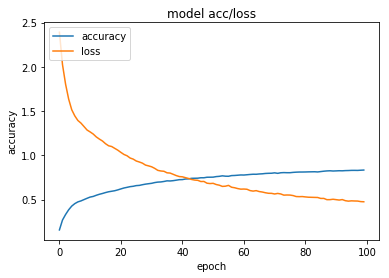

In [45]:
# plot loss & accuracy for train set
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('model acc/loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [46]:
# save model weights together with architecture
model.save('model.h5')

In [64]:
test_idx = 888
res = model.predict(train_wav[test_idx].reshape((-1, 8000, 1)))
print(label_num2word[np.argmax(res)], label_num2word[np.argmax(train_label[test_idx])])
librosa.output.write_wav('x.wav', train_wav[test_idx], 8000)
sr, ss = wavfile.read('x.wav')
ipd.Audio(ss, rate=8000)

down down


In [53]:
Y_test = np.argmax(train_label, axis=1) # Convert one-hot to index
y_pred = np.argmax(model.predict(train_wav), axis=1) # Convert one-hot to index
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.23      0.34      4314
           1       0.82      0.16      0.26      4196
           2       0.81      0.23      0.36      4124
           3       0.91      0.15      0.26      4304
           4       0.88      0.13      0.23      4330
           5       0.90      0.14      0.24      4310
           6       0.86      0.18      0.29      4210
           7       0.89      0.22      0.35      4286
           8       0.93      0.18      0.30      4348
           9       0.87      0.14      0.23      4202
          10       0.17      0.95      0.29      6000
          11       0.37      0.98      0.54      3996

    accuracy                           0.32     52620
   macro avg       0.75      0.31      0.31     52620
weighted avg       0.74      0.32      0.31     52620



In [ ]:
# https://www.kaggle.com/hemingwei/tensorflow-speech-recognition-public-test-set
# !7z x ../input/tensorflow-speech-recognition-public-test-set/test.7z

In [ ]:
# predict for test data and output result
# test_path = './test/audio/'
# df = pd.read_csv('../input/tensorflow-speech-recognition-challenge/sample_submission.csv')
# # test_data = np.zeros((158538, 8000))
# # for i in range(len(df)):
# #     samples, sample_rate = librosa.load(join(test_path, df.loc[i]['fname']), sr=16000)
# #     samples = librosa.resample(samples, sample_rate, 8000)
# #     test_data[i] = samples
# # test_data = test_data.reshape(-1, 8000, 1)
# # result = model.predict(test_data)
# for i in range(len(df)):
#     samples, sample_rate = librosa.load(join(test_path, df.loc[i]['fname']), sr=16000)
#     samples = librosa.resample(samples, sample_rate, 8000)
#     result = model.predict(np.reshape(samples, (-1, 8000, 1)))
#     df.loc[i]['label'] = label_num2word[np.argmax(result)]
# df.to_csv('submission.cvs', index=False)

In [ ]:
# ls -lh

In [ ]:
# download output file
# from IPython.display import FileLink
# FileLink('model.h5')

In [ ]:
# bbb = load_model('model.h5')

In [ ]:
# train_wav[:1].shape

In [ ]:
# bbb.predict(train_wav[:1])